# 导入函数库

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras  # 在TF2.0版本中,已经是自带Keras了,所以不需要额外安装
import tensorflow_datasets as tfds # 这个是之前说过的Tensorflow Datasets
import matplotlib.pyplot as plt

# 如果出现显存不够的错误,把这个代码加上

In [2]:
# 加入下面这个代码片段主要是因为TF2.0对RTX20系列显卡支持不是很好,容易爆显存,所以设置成用多少占多少显存,而不是一次性全占了(默认)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# 定义网络结构

## 一些参数设置

In [3]:
layers = tf.keras.layers
models = tf.keras.models
keras_utils = tf.keras.utils

In [4]:
WEIGHTS_PATH_NO_TOP = ('https://github.com/fchollet/deep-learning-models/'
                       'releases/download/v0.2/'
                       'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')  # 此处的预训练模型不带全连接层

## ResNet50模型改写用于caltech101分类

In [5]:
def identity_block(input_tensor, kernel_size, filters, stage, block):
    filters1, filters2, filters3 = filters
    bn_axis = 3
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = layers.Conv2D(filters1, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size,
                      padding='same',
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = layers.Activation('relu')(x)
    return x

In [6]:
def conv_block(input_tensor,
               kernel_size,
               filters,
               stage,
               block,
               strides=(2, 2)):
    filters1, filters2, filters3 = filters
    bn_axis = 3
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = layers.Conv2D(filters1, (1, 1), strides=strides,
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size, padding='same',
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = layers.Conv2D(filters3, (1, 1), strides=strides,
                             kernel_initializer='he_normal',
                             name=conv_name_base + '1')(input_tensor)
    shortcut = layers.BatchNormalization(
        axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

In [7]:
def ResNet50(input_shape=(224, 224, 3),
         classes=102):
    img_input = layers.Input(shape=input_shape)  # 输入节点
    
    bn_axis = 3
    x = layers.ZeroPadding2D(padding=(3, 3), name='conv1_pad')(img_input)
    x = layers.Conv2D(64, (7, 7),
                      strides=(2, 2),
                      padding='valid',
                      kernel_initializer='he_normal',
                      name='conv1')(x)
    x = layers.BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = layers.Activation('relu')(x)
    x = layers.ZeroPadding2D(padding=(1, 1), name='pool1_pad')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')
    
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu', name='fc1')(x)
    x = layers.Dense(classes, activation='softmax', name='predictions')(x)
    
    inputs = img_input  # inputs是输入节点
    outputs = x # x是输出节点
    model = models.Model(inputs, outputs , name='resnet50')  # 生成一个Model, 需要指定输入和输出
    
    weights_path = keras_utils.get_file(
        'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',  # 此处加载的是不存在全连接层的预训练模型
        WEIGHTS_PATH_NO_TOP,
        cache_subdir='models')
    model.load_weights(weights_path, by_name=True)  
    # 加载在ImageNet上预训练过的模型，注意by_name参数很有用，把layer和layer name对应上了
    
    return model

## 声明一个ResNet50模型实例

In [8]:
model = ResNet50()

## 模型训练日志记录

In [9]:
log_dir = './logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

## 数据增强

In [10]:
def convert(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
    image = tf.image.resize_with_crop_or_pad(image, 256, 256) # Add 6 pixels of padding
    image = tf.image.random_crop(image, size=[224, 224, 3]) # Random crop back to 32x32
    return image, label

def augment(image,label):
    image,label = convert(image, label)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
    return image,label

## 数据读取并预处理

In [11]:
# 此处使用tfds的方式构建data pipeline
(raw_test, raw_train), metadata = tfds.load(
    'caltech101', # 数据集名称，这个是cifar100分类数据集，共100个类别
    split=['test', 'train'], # 这里的raw_test和split的'test'对应，raw_train和split的'train'对应
    with_info=True, # 这个参数和metadata对应
    as_supervised=True, # 这个参数的作用是返回tuple形式的(input, label),举个例子，raw_test=tuple(input, label)
    shuffle_files=True,
    data_dir='./tensorflow_datasets'
)

BATCH_SIZE = 16
SHUFFLE_BUFFER_SIZE = 1000

# 可以体验下这里是否加prefetch(tf.data.experimental.AUTOTUNE)和cache()的区别，对训练速度，以及CPU负载有影响
train_batches = raw_train.shuffle(SHUFFLE_BUFFER_SIZE, reshuffle_each_iteration=True).map(augment).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_batches = raw_test.map(convert).batch(BATCH_SIZE)

## 进行模型训练

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

model.fit(
    train_batches,
    epochs=55,
    callbacks=[tensorboard_callback]
)

Epoch 1/60
383/383 [==============================] - 26s 69ms/step - loss: 4.6185 - accuracy: 0.0441
Epoch 2/60
383/383 [==============================] - 26s 68ms/step - loss: 4.5570 - accuracy: 0.1448
Epoch 3/60
383/383 [==============================] - 26s 68ms/step - loss: 4.4554 - accuracy: 0.2160
Epoch 4/60
383/383 [==============================] - 26s 68ms/step - loss: 4.4033 - accuracy: 0.2673
Epoch 5/60
383/383 [==============================] - 26s 68ms/step - loss: 4.3494 - accuracy: 0.3239
Epoch 6/60
383/383 [==============================] - 26s 68ms/step - loss: 4.2966 - accuracy: 0.3758
Epoch 7/60
383/383 [==============================] - 26s 68ms/step - loss: 4.2622 - accuracy: 0.4046
Epoch 8/60
383/383 [==============================] - 26s 69ms/step - loss: 4.2363 - accuracy: 0.4232
Epoch 9/60
383/383 [==============================] - 26s 68ms/step - loss: 4.2183 - accuracy: 0.4376
Epoch 10/60
383/383 [==============================] - 26s 68ms/step - loss: 4.199

## 模型训练后预测展示

leopards
camera
motorbikes
leopards
dollar_bill


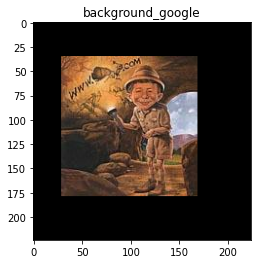

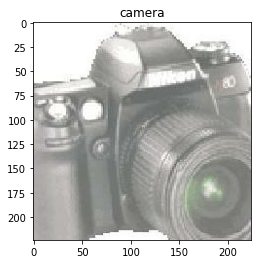

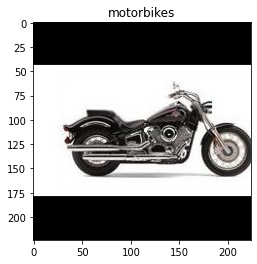

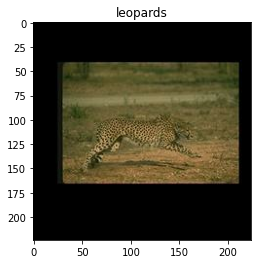

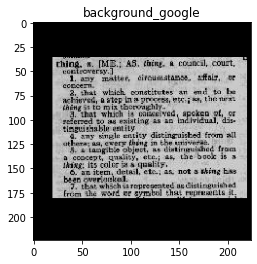

In [13]:
get_label_name = metadata.features['label'].int2str

for image, label in raw_test.take(5):
    image, label = convert(image, label)
    predict = np.argmax(model.predict(np.expand_dims(image, axis=0)))
    print(get_label_name(predict))
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))

## Baseline的test acc，并保存模型

In [14]:
# 此处我们可以看到Baseline的test acc和inference速度为6ms/step
_, baseline_model_accuracy = model.evaluate(test_batches, verbose=1)
print('Baseline test accuracy: ', baseline_model_accuracy)

keras_file = './test.h5'
tf.keras.models.save_model(model, keras_file, include_optimizer=False)
print('Saved baseline model to: ', keras_file)

761/761 [==============================] - 16s 21ms/step - loss: 3.8936 - accuracy: 0.7576
Baseline test accuracy:  0.7575607895851135
Saved baseline model to:  ./test.h5
